Churn Prediction Tutorial
July 17, 2017
Author: https://github.com/beilmanmich


In [1]:
import sys
print(sys.version)

2.7.13 |Anaconda custom (x86_64)| (default, Dec 20 2016, 23:05:08) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


# Churn Rate Introduction

"Churn Rate" is a business term describing the rate at which customers leave or cease paying for a product or service. It's a critical figure in many businesses, as it's often the case that acquiring new customers is a lot more costly than retaining existing ones (in some cases, 5 to 20 times more expensive).

Understanding what keeps customers engaged, therefore, is incredibly valuable, as it is a logical foundation from which to develop retention strategies and roll out operational practices aimed to keep customers from walking out the door. Consequently, there's growing interest among companies to develop better churn-detection techniques, leading many to look to data mining and machine learning for new and creative approaches.

Predicting churn is particularly important for businesses w/ subscription models such as cell phone, cable, or merchant credit card processing plans. But modeling churn has wide reaching applications in many domains. For example, casinos have used predictive models to predict ideal room conditions for keeping patrons at the blackjack table and when to reward unlucky gamblers with front row seats to Celine Dion. Similarly, airlines may offer first class upgrades to complaining customers. The list goes on.

Wait, don't go!

So what are some of ops strategies that companies employ to prevent churn? Well, reducing churn, it turns out, often requires non-trivial resources. Specialized retention teams are common in many industries and exist expressly to call down lists of at-risk customers to plead for their continued business.

# Marketing Examples

![alt text]('https://github.com/beilmanmich/churn/blob/master/misc/Starbucks.png' "Starbucks Example")
![alt text]('https://github.com/beilmanmich/churn/blob/master/misc/RunKeeper.png' "RunKeeper Example")
![alt text]('https://github.com/beilmanmich/churn/blob/master/misc/PinkBerry.png' "PinkBerry Example")

Organizing and running such teams is tough. From an ops perspective, cross-geographic teams must be well organized and trained to respond to a huge spectrum of customer complaints. Customers must be accurately targeted based on churn-risk, and retention treatments must be well-conceived and correspond reasonably to match expected customer value to ensure the economics make sense. Spending $1,000 on someone who wasn't about to leave can get expensive pretty quickly.

Within this frame of mind, efficiently dealing with turnover is an exercise of distinguishing who is likely to churn from who is not using the data at our disposal. The remainder of this post will explore a simple case study to show how Python and its scientific libraries can be used to predict churn and how you might deploy such a solution within operations to guide a retention team.

# The Dataset

The data set we'll be using is a longstanding telecom customer data set. More can be found here: https://data.world/earino/churn, or here: https://www.sgi.com/tech/mlc/db/

The data is straightforward. Each row represents a subscribing telephone customer. Each column contains customer attributes such as phone number, call minutes used during different times of day, charges incurred for services, lifetime account duration, and whether or not the customer is still a customer.

In [5]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
# from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


%matplotlib inline

In [7]:
churn_df = pd.read_csv('churn.csv')
col_names = churn_df.columns.tolist()

print "Column names:"
print col_names

to_show = col_names[:6] + col_names[-6:]

print "\nSample data:"
churn_df[to_show].head(6)

Column names:
['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']

Sample data:


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,8.41,10.1,3,2.73,3,False.
5,AL,118,510,391-8027,yes,no,9.18,6.3,6,1.70,0,False.


We'll be keeping the statistical model pretty simple for this example so the feature space is almost unchanged from what you see above. The following code simply drops irrelevant columns and converts strings to boolean values (since models don't handle "yes" and "no" very well). The rest of the numeric columns are left untouched.

In [8]:
# Isolate target data
churn_result = churn_df['Churn?']
y = np.where(churn_result == 'True.',1,0)

In [18]:
# We don't need these columns
to_drop = ['State','Area Code','Phone','Churn?']
churn_feat_space = churn_df.drop(to_drop,axis=1)

In [19]:
# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
yes_no_cols = ["Int'l Plan","VMail Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

In [20]:
# Pull out features for future use
features = churn_feat_space.columns
print features

Index([u'Account Length', u'Int'l Plan', u'VMail Plan', u'VMail Message',
       u'Day Mins', u'Day Calls', u'Day Charge', u'Eve Mins', u'Eve Calls',
       u'Eve Charge', u'Night Mins', u'Night Calls', u'Night Charge',
       u'Intl Mins', u'Intl Calls', u'Intl Charge', u'CustServ Calls'],
      dtype='object')


In [21]:
X = churn_feat_space.as_matrix().astype(np.float)

# This is important
scaler = StandardScaler()
X = scaler.fit_transform(X)
print "Feature space holds %d observations and %d features" % X.shape
print "Unique target labels:", np.unique(y)

Feature space holds 3333 observations and 17 features
Unique target labels: [0 1]


One slight side note. Many predictors care about the relative size of different features even though those scales might be arbitrary. For instance: the number of points a basketball team scores per game will naturally be a couple orders of magnitude larger than their win percentage. But this doesn't mean that the latter is 100 times less signifigant. StandardScaler fixes this by normalizing each feature to a range of around 1.0 to -1.0 thereby preventing models from misbehaving. Well, at least for that reason.

Great, I now have a feature space X and a set of target values y. On to the predictions!

# How good is your model?

Express, test, cycle. A machine learning pipeline should be anything but static. There are always new features to design, new data to use, new classifiers to consider each with unique parameters to tune. And for every change it's critical to be able to ask, "Is the new version better than the last?" So how do I do that?

As a good start, cross validation will be used throught this example. Cross validation attempts to avoid overfitting (training on and predicting the same datapoint) while still producing a prediction for each observation dataset. This is accomplished by systematically hiding different subsets of the data while training a set of models. After training, each model predicts on the subset that had been hidden to it, emulating multiple train-test splits. When done correctly, every observation will have a 'fair' corresponding prediction.

Here's what that looks like using scikit-learn libraries.

In [22]:
from sklearn.cross_validation import KFold

def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=3,shuffle=True)
    y_pred = y.copy()
    
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

Let's compare three fairly unique algorithms support vector machines, random forest, and k-nearest-neighbors. Nothing fancy here, just passing each to cross validation and determining how often the classifier predicted the correct class.

In [23]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import average_precision_score

def accuracy(y_true,y_pred):
    # NumPy interpretes True and False as 1. and 0.
    return np.mean(y_true == y_pred)

print "Logistic Regression:"
print "%.3f" % accuracy(y, run_cv(X,y,LR))
print "Gradient Boosting Classifier"
print "%.3f" % accuracy(y, run_cv(X,y,GBC))
print "Support vector machines:"
print "%.3f" % accuracy(y, run_cv(X,y,SVC))
print "Random forest:"
print "%.3f" % accuracy(y, run_cv(X,y,RF))
print "K-nearest-neighbors:"
print "%.3f" % accuracy(y, run_cv(X,y,KNN))

Logistic Regression:
0.860
Gradient Boosting Classifier
0.951
Support vector machines:
0.916
Random forest:
0.944
K-nearest-neighbors:
0.890


Based on the above, we can simply choose the model with the greatest accuracy, correct? In our case Gradient Boosting Classifier is our choice, correct? Or should we also consider other measures, such as precision?

![alt text](precision_accuracy.png "Precision vs Accuracy")

# Precision and recall

Measurements aren't golden formulas which always spit out high numbers for good models and low numbers for bad ones. Inherently they convey something sentiment about a model's performance, and it's the job of the human designer to determine each number's validity. The problem with accuracy is that outcomes aren't necessarily equal. If my classifier predicted a customer would churn and they didn't, that's not the best but it's forgivable. However, if my classifier predicted a customer would return, I didn't act, and then they churned... that's really bad.

![alt text](precision_recall.png "Precision vs Accuracy")

We'll be using another built in _scikit-learn_ function to construction a confusion matrix. A confusion matrix is a way of visualizing predictions made by a classifier and is just a table showing the distribution of predictions for a specific class. The x-axis indicates the true class of each observation (if a customer churned or not) while the y-axis corresponds to the class predicted by the model (if my classifier said a customer would churned or not).

# Confusion matrix and confusion tables:

The columns represent the actual class and the rows represent the predicted class. Lets evaluate performance:

  | condition True | condition False
- |-------------- | ---------------
**prediction True** | True Positive | False Positive
**prediction False**	|False Negative	|True Negative

Sensitivity, Recall or True Positive Rate quantify the models ability to predict our positive classes.
$$TPR = \frac{ TP}{TP + FN}$$
Specificity or True Negative Rate quantify the models ability to predict our Negative classes.
$$TNR = \frac{ TN}{FP + TN}$$

# Example:

  | Spam | Ham
- |-------------- | ---------------
prediction Spam | 100 | 50
prediction Ham	| 75	| 900

$$TNR = \frac{900}{50 + 900} = 94.73% $$ 

[[2815   35]
 [ 256  227]]


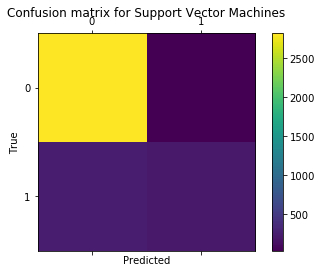

[[2824   26]
 [ 154  329]]


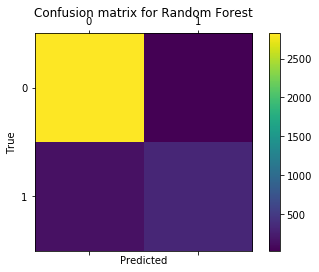

[[2808   42]
 [ 308  175]]


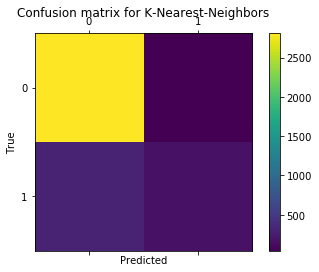

[[2817   33]
 [ 128  355]]


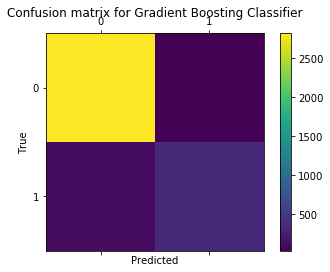

[[2763   87]
 [ 384   99]]


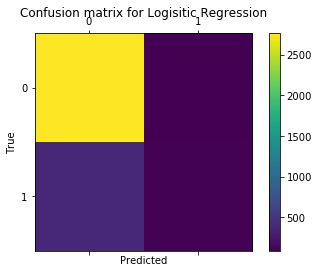

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def draw_confusion_matrices(confusion_matricies,class_names):
    class_names = class_names.tolist()
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        print(cm)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm)
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ( "Support Vector Machines", confusion_matrix(y,run_cv(X,y,SVC)) ),
    ( "Random Forest", confusion_matrix(y,run_cv(X,y,RF)) ),
    ( "K-Nearest-Neighbors", confusion_matrix(y,run_cv(X,y,KNN)) ),
    ( "Gradient Boosting Classifier", confusion_matrix(y,run_cv(X,y,GBC)) ),
    ( "Logisitic Regression", confusion_matrix(y,run_cv(X,y,LR)) )
]

# Pyplot code not included to reduce clutter
# from churn_display import draw_confusion_matrices
%matplotlib inline

draw_confusion_matrices(confusion_matrices,class_names)

An important question to ask might be: *"When an individual churns, how often does my classifier predict that correctly?"* This measurement is called "recall" and a quick look at these diagrams can demonstrate that gradient boosting classifier is clearly best for this criteria, followed closely by random forest classifier. Out of all the churn cases (outcome "1") gradient boosting correctly retrieved 355 of 482, translating to a churn "recall" over 73% (355/483=73.49%), while random forest correctly recalled 329 of 482, 68%, both models clearly out perfmored  support vector machines (≈47%), k-nearest-neighbors (≈36%), or logistic regression (≈20%).

Another question of importance is "precision" or, When a classifier predicts an individual will churn, how often does that individual actually churn? The differences in sematic are small compared to the previous question, but it makes quite a difference. For precision, random forest slightly outperforms gradient boosting at about 92.67% precision (329 out of 355)  compared to gradient boosting at 91.49% (355 out of 388). SVM ≈87% (227/262) and KNN ≈81% (175/217) show the advantages of "true" machine learning versus regression models, our logistic regression model lagged with ≈53% (99/186).

While, gradient boosting was more accurate with slightly higher recall, random performance outperformed on precision. This slightly outperformance may be enough motivation to choose the random forest model over gradient boosting. When different measurements do return a different pecking order, understanding the values and tradeoffs of each rating should effect how you proceed.

# ROC Plots & AUC

Another important metric to consider is ROC plots. [This paper](https://ccrma.stanford.edu/workshops/mir2009/references/ROCintro.pdf) serves as a great academic introduction to ROC analysis.

Simply put, the area under the curve (AUC) of a receiver operating characteristic (ROC) curve is a way to reduce ROC performance to a single value representing expected performance. To explain with a little more detail, a ROC curve plots the true positives (sensitivity) vs. false positives (1 − specificity), for a binary classifier system as its discrimination threshold is varied. Since a random method describes a horizontal curve through the unit interval, it has an AUC of 0.5. Minimally, classifiers should perform better than this, and the extent to which they score higher than one another (meaning the area under the ROC curve is larger), they have better expected performance.

**Maximize the area under the curve**

Random forests:


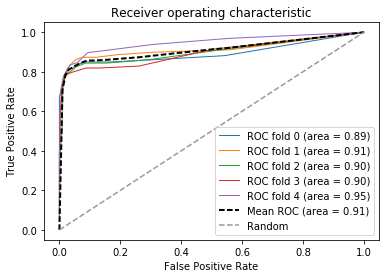

Gradient Boosting Classifier:


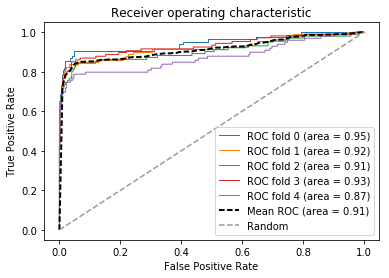

In [26]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

def plot_roc(X, y, clf_class, **kwargs):
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train_index, test_index) in enumerate(kf):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= len(kf)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
      

# print "Support vector machines:"
# plot_roc(X,y,SVC,probability=True)

print "Random forests:"
plot_roc(X,y,RF,n_estimators=18)

# print "K-nearest-neighbors:"
# plot_roc(X,y,KNN)

print "Gradient Boosting Classifier:"
plot_roc(X,y,GBC)

# Feature Importance

Now that we understand the accuracy of each individual model for our particular dataset, let's dive a little deeper to get a better understanding of what features or behaviours are causing our customers to churn. In the next section, we will be using a RandomForestClassifer to build an ensemble of decision trees to predict whether a customer will churn or not churn. One of the first steps in building a decision tree to calculating the information gain associated with splitting on a particular feature. (More on this later.)

Let's look at the Top 10 features in our dataset that contribute to customer churn:

Feature ranking:
1. Account Length (0.126889)
2. Int'l Plan (0.112778)
3. VMail Plan (0.083519)
4. VMail Message (0.073346)
5. Day Mins (0.066198)
6. Day Calls (0.037398)
7. Day Charge (0.034065)
8. Eve Mins (0.032638)
9. Eve Calls (0.029189)
10. Eve Charge (0.017995)


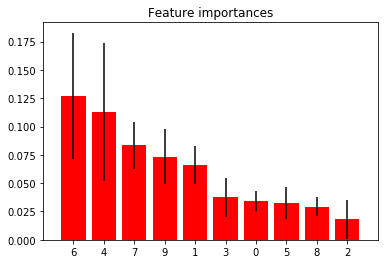

In [27]:
train_index,test_index = train_test_split(churn_df.index)

forest = RF()
forest_fit = forest.fit(X[train_index], y[train_index])
forest_predictions = forest_fit.predict(X[test_index])

importances = forest_fit.feature_importances_[:10]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

# Plot the feature importances of the forest
#import pylab as pl
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices], yerr=std[indices], color="r", align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()

# Thinking in Probabilities

Decision making often favors probability over simple classifications. There's plainly more information in statements like "there's a 20% chance of rain tomorrow" and "about 55% of test takers pass the California bar exam" than just saying "it shouldn't rain tomorrow" or "you'll probably pass." Probability predictions for churn also allow us to gauge a customers expected value, and their expected loss. Who do you want to reach out to first, the client with a 80% churn risk who pays 20,000 annually, or the client who's worth 100,000 a year with a 40% risk? How much should you spend on each client?

While I'm moving a bit away from my expertise, being able to ask that question requires producing predictions a little differently. However, *scikit-learn* makes moving to probabilities easy; my models have *predict_proba()* built right into their class objects. This is the same cross validation code with only a few lines changed.

In [28]:
def run_prob_cv(X, y, clf_class, roc=False, **kwargs):
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

# How good is good?

Determining how good a predictor which gives probabilities rather than classes is a bit more difficult. If I predict there's a 20% likelihood of rain tomorrow I don't get to live out all the possible outcomes of the universe. It either rains or it doesn't.

What helps is that the predictors aren't making one prediction, they're making 3000+. So for every time I predict an event to occur 20% of the time I can see how often those events actually happen. Here's we'll use pandas to help me compare the predictions made by random forest against the actual outcomes.

In [37]:
import warnings
warnings.filterwarnings('ignore')

# Use 10 estimators so predictions are all multiples of 0.1
pred_prob = run_prob_cv(X, y, RF, n_estimators=10)
pred_churn = pred_prob[:,1]
is_churn = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_churn)
counts[:]

0.0    1725
0.1     739
0.2     288
0.3     123
0.8      81
0.9      76
0.7      73
1.0      60
0.5      59
0.6      55
0.4      54
dtype: int64

In [38]:
from collections import defaultdict
true_prob = defaultdict(float)

# calculate true probabilities
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
true_prob = pd.Series(true_prob)

# pandas-fu
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

,pred_prob,count,true_prob
0,0.0,1725,0.027826
1,0.1,739,0.036536
2,0.2,288,0.041667
3,0.3,123,0.121951
4,0.4,54,0.444444
5,0.5,59,0.593220
6,0.6,55,0.763636
7,0.7,73,0.945205
8,0.8,81,0.950617
9,0.9,76,0.973684


We can see that random forests predicted that 76 individuals would have a 0.9 proability of churn and in actuality that group had a ~0.97 rate.

# Calibration and Descrimination

Using the DataFrame above we can draw a pretty simple graph to help visualize probability measurements. The x axis represents the churn probabilities which random forest assigned to a group of individuals. The y axis is the actual rate of churn within that group, and each point is scaled relative to the size of the group.

![alt text](ggplot_RF.png "RF")

Calibration is a relatively simple measurement and can be summed up as so: Events predicted to happen 60% of the time should happen 60% of the time. For all individuals I predict to have a churn risk of between 30 and 40%, the true churn rate for that group should be about 35%. For the graph above think of it as, How close are my predictions to the red line?

Discrimination measures How far are my predictions away from the green line? Why is that important?

Well, if we assign a churn probability of 15% to every individual we'll have near perfect calibration due to averages, but I'll be lacking any real insight. Discrimination gives a model a better score if it's able to isolate groups which are further from the base set.

Equations are replicated from [Yang, Yates, and Smith (1991)](https://www.researchgate.net/profile/Ilan_Yaniv2/publication/232479757_Measures_of_discrimination_skill_in_probabilistic_judgment/links/02bfe511b6091e16e1000000/Measures-of-discrimination-skill-in-probabilistic-judgment.pdf)

In [58]:
# %load_ext rmagic
%load_ext rpy2.ipython
# We need ggplot2
%R require(ggplot2)

ImportError: No module named rpy2.ipython

In [59]:
baseline = np.mean(is_churn)

In [64]:
%load_ext rpy2.ipython
%R require(ggplot2)

array([0], dtype=int32)

In [67]:
from rpy2.robjects.packages import importr
importr("ggplot2")

RRuntimeError: Error in loadNamespace(name) : there is no package called ‘ggplot2’


In [70]:
%%R -i counts,baseline -w 800 -h 600 -u px

ggplot(counts,aes(x=pred_prob,y=true_prob,size=count)) + 
    geom_point(color='blue') + 
    stat_function(fun = function(x){x}, color='red') + 
    stat_function(fun = function(x){baseline}, color='green') + 
    xlim(-0.05,  1.05) + ylim(-0.05,1.05) + 
    ggtitle("RF") + 
    xlab("Predicted probability") + ylab("Relative  of outcome")

SyntaxError: invalid syntax (<ipython-input-70-bfb4b548b80b>, line 3)

In [51]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from __future__ import division 
from operator import idiv


      
def print_measurements(pred_prob):
    churn_prob, is_churn = pred_prob[:,1], y == 1
    print "  %-20s %.4f" % ("Calibration Error", calibration(churn_prob, is_churn))
    print "  %-20s %.4f" % ("Discrimination", discrimination(churn_prob,is_churn))

    print "Note -- Lower calibration is better, higher discrimination is better"


In [52]:
print "Support vector machines:"
print_measurements(run_prob_cv(X,y,SVC,probability=True))

print "Random forests:"
print_measurements(run_prob_cv(X,y,RF,n_estimators=18))

print "K-nearest-neighbors:"
print_measurements(run_prob_cv(X,y,KNN))

print "Gradient Boosting Classifier:"
print_measurements(run_prob_cv(X,y,GBC))

print "Random Forest:"
print_measurements(run_prob_cv(X,y,RF))

Support vector machines:


NameError: global name 'calibration' is not defined

In [32]:
# import warnings
# warnings.filterwarnings('ignore')

# # Use 10 estimators so predictions are all multiples of 0.1
# pred_prob = run_prob_cv(X, y, GBC, n_estimators=10)
# pred_churn = pred_prob[:,1]
# is_churn = y == 1

# # Number of times a predicted probability is assigned to an observation
# counts = pd.value_counts(pred_churn)
# counts[:]

# from collections import defaultdict
# true_prob = defaultdict(float)

# # calculate true probabilities
# for prob in counts.index:
#     true_prob[prob] = np.mean(is_churn[pred_churn == prob])
# true_prob = pd.Series(true_prob)

# # pandas-fu
# counts = pd.concat([counts,true_prob], axis=1).reset_index()
# counts.columns = ['pred_prob', 'count', 'true_prob']
# counts

,pred_prob,count,true_prob
0,0.069840,439,0.034169
1,0.070352,383,0.046997
2,0.075294,7,0.285714
3,0.077609,461,0.019523
4,0.077876,449,0.020045
5,0.078045,459,0.030501
6,0.078339,56,0.035714
7,0.079936,1,0.000000
8,0.082707,1,1.000000
9,0.085302,2,0.000000
